<a href="https://colab.research.google.com/github/steve-shim/dlgom/blob/main/deeplearning/%EB%8B%A4%EC%A4%91%EB%B6%84%EB%A5%98%20%EA%B5%AC%ED%98%84%20Fashion%20Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

class MultiClassNetwork:

  def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
      self.units = units  # 은닉층의 뉴런 개수(100)
      self.batch_size = batch_size
      self.w1 = None  # 은닉층에 적용되는 가중치
      self.b1 = None  # 은닉층의 절편
      self.w2 = None  # 출력층에 적용되는 가중치
      self.b2 = None  # 출력층의 절편
      self.a1 = None  # 은닉층의 활성화 출력
      self.losses = []     # 훈련 손실
      self.val_losses = [] # 검증 손실
      self.lr = learning_rate
      self.l1 = l1
      self.l2 = l2

  def forpass(self, x):             # x_batch:(256,784)
      z1 = np.dot(x, self.w1) + self.b1  # (256,784) @ (784,100) -> (256,100)
      self.a1 = self.sigmoid(z1)    
      z2 = np.dot(self.a1, self.w2) + self.b2 # (256,100) @ (100,10) -> (256,10)
      return z2

  def backprop(self, x, err): # (256,784), (256,10)
      m = len(x) # 샘플 개수
      # 출력층의 가중치와 절편에 대한 그레이디언트를 계산
      w2_grad = np.dot(self.a1.T, err) / m  # (100,256) @ (256,10) -> (100,10)
      b2_grad = np.sum(err) / m
      # 시그모이드 함수까지 그레이디언트를 계산
      err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1-self.a1) # (256,10) @ (10,100) -> (256,100)
      # 은닉층의 가중치와 절편에 대한 그레이디언트를 계산
      w1_grad = np.dot(x.T, err_to_hidden) / m # (784,256) @ (256,100) -> (784,100)
      b1_grad = np.sum(err_to_hidden, axis=0) / m # (256,100) -> (100,)
      return w1_grad, b1_grad, w2_grad, b2_grad

  def sigmoid(self, z):
      z = np.clip(z, -100, None)
      a = 1 / (1 + np.exp(-z))
      return a

  def softmax(self, z):
      z = np.clip(z, -100, None)
      exp_z = np.exp(z)
      return exp_z / np.sum(exp_z, axis=1).reshape(-1,1)

  def init_weights(self, n_features, n_classes): # 784, 10
      self.w1 = np.random.normal(0, 1, 
                                (n_features, self.units)) # (특성 개수, 은닉층의 크기) 은닉층에 적용되는 가중치
      self.b1 = np.zeros(self.units) # 은닉층의 뉴런의 갯수만큼 은닉층의 바이어스가 정해진다
      self.w2 = np.random.normal(0, 1, 
                                (self.units, n_classes))  # (은닉층의 크기, 클래스 개수)
      self.b2 = np.zeros(n_classes)  # 클래스 갯수만큼 바이어스값 초기화

  def fit(self, x, y, epochs=100, x_val=None, y_val=None): # x:(48000,784) y:(48000,10) x_val:(12000,784), y_val:(12000,10)
      np.random.seed(42)
      self.init_weights(x.shape[1], y.shape[1]) # 784, 10
      # epochs만큼 반복
      for i in range(epochs):
        loss = 0 # epochs 마다 손실을 기록한다
        print('.', end='')
        # 제너레이터 함수에서 반환한 미니 배치를 순환합니다
        for x_batch, y_batch in self.gen_batch(x, y):  # x:(48000,784) y:(48000,10)
          a = self.training(x_batch, y_batch)          # x_batch:(256,784) y_batch:(256,10) -> a:(256,10)
          a = np.clip(a, 1e-10, 1-1e-10)
          loss += np.sum(-y_batch * np.log(a))         # loss -> 스칼라값
        self.losses.append((loss + self.reg_loss()) / len(x)) # 훈련세트 전체 크기로 나눈다 (48000)
        # epoch 마다 검증 세트에 대한 손실 계산
        self.update_val_loss(x_val, y_val)             # x_val:(12000,784), y_val:(12000,10)

    
  def gen_batch(self, x, y): # x:(48000,784) y:(48000,10)
      length = len(x)  # 48000
      bins = length // self.batch_size # 48000/256 -> 187.5
      if length % self.batch_size: # 미니배치횟수 187+1 -> 188회
        bins += 1 
      indexes = np.random.permutation(np.arange(len(x))) # 전체 인덱스를 섞는다
      x = x[indexes]
      y = y[indexes]
      for i in range(bins): # 미니배치횟수만큼 루프를 돈다 (48000 = 256 x 187 + 128 x 1)
        start = self.batch_size * i
        end = self.batch_size * (i+1)
        yield x[start:end], y[start:end] # batch_size만큼 슬라이싱하여 반환

  def training(self, x, y): # x_batch:(256,784) y_batch:(256,10)
      m = len(x)              # 256
      z = self.forpass(x)     # x_batch:(256,784) -> (256,10)
      a = self.softmax(z)     # 활성화 함수적용(다중분류니까 softmax!) -> (256,10)
      err = -(y-a)            # (256,10)
      w1_grad , b1_grad, w2_grad, b2_grad = self.backprop(x, err) # (256,784), (256,10)
      w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m  # 배치사이즈로 나눈다 (256)
      w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m  # 배치사이즈로 나눈다
      # 은닉층의 가중치와 절편을 업데이트
      self.w1 -= self.lr * w1_grad
      self.b1 -= self.lr * b1_grad
      # 출력층의 가중치와 절편을 업데이트
      self.w2 -= self.lr * w2_grad
      self.b2 -= self.lr * b2_grad
      return a  # (256,10)

  def predict(self, x):   # x:(12000, 784)
      z = self.forpass(x) # z:(12000, 10)
      return np.argmax(z, axis=1) # (12000,) -> 각 샘플의 10개 클래스 중에서 가장 예측확률이 높은 인덱스를 반환

  def score(self, x, y):  # x:(12000, 784), y:(12000, 10) = (검증세트 정답)
      # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환
      return np.mean(self.predict(x) == np.argmax(y, axis=1)) # (12000,) == (12000,)

  def reg_loss(self):
      # 은닉층과 출력층의 가중치에 규제를 적용
      return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
             self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

  def update_val_loss(self, x_val, y_val):
      z = self.forpass(x_val) # (12000, 10)
      a = self.softmax(z) # (12000, 10)
      a = np.clip(a, 1e-10, 1-1e-10) 
      val_loss = np.sum(-y_val * np.log(a))
      self.val_losses.append((val_loss + self.reg_loss()) / len(y_val)) # 검증 데이터 전체 크기로 나눈다 (12000)


  
      

In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

print(x_train_all.shape, y_train_all.shape)
print(x_test.shape, y_test.shape)
print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
(48000, 28, 28) (12000, 28, 28)
(48000,) (12000,)


In [3]:
#np.bincount(y_train)
np.unique(y_train, return_counts=True)[1]

array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800])

(28, 28)


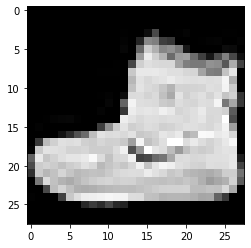

In [4]:
import matplotlib.pyplot as plt

print(x_train_all[0].shape)
plt.imshow(x_train_all[0], cmap='gray')
plt.show()

In [5]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [6]:
x_train = x_train / 255
x_val = x_val / 255

x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)

print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


In [7]:
tf.keras.utils.to_categorical([0, 1, 3])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [8]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [9]:
print(y_train.shape, y_val.shape)
print(y_train_encoded.shape, y_val_encoded.shape)
print(y_train[0], y_train_encoded[0])

(48000,) (12000,)
(48000, 10) (12000, 10)
6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [10]:
fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, 
       x_val=x_val, y_val=y_val_encoded, epochs=40)

........................................

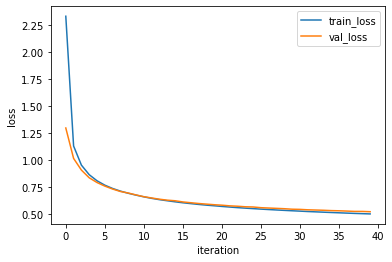

In [11]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [12]:
fc.score(x_val, y_val_encoded)

0.8150833333333334

In [13]:
fc.score(x_train, y_train_encoded)

0.8204375

In [16]:
print(y_test[:10])

[9 2 1 1 6 1 4 6 5 7]


In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(100, activation='sigmoid', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train_encoded, epochs=40,
                    validation_data=(x_val, y_val_encoded))


Epoch 1/40
1500/1500 [==============================] - 4s 2ms/step - loss: 1.3760 - accuracy: 0.6470 - val_loss: 0.9674 - val_accuracy: 0.7321
Epoch 2/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.8435 - accuracy: 0.7442 - val_loss: 0.7501 - val_accuracy: 0.7557
Epoch 3/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.7073 - accuracy: 0.7662 - val_loss: 0.6600 - val_accuracy: 0.7820
Epoch 4/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6417 - accuracy: 0.7808 - val_loss: 0.6083 - val_accuracy: 0.7919
Epoch 5/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6001 - accuracy: 0.7948 - val_loss: 0.5725 - val_accuracy: 0.8053
Epoch 6/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5708 - accuracy: 0.8031 - val_loss: 0.5468 - val_accuracy: 0.8108
Epoch 7/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5485 - accuracy: 0.8104 - val_loss: 0.5275 - val_accuracy:

In [21]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


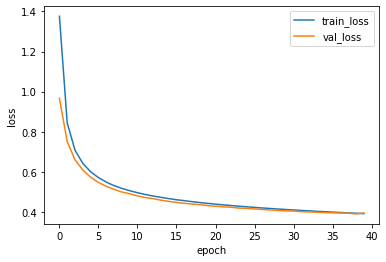

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

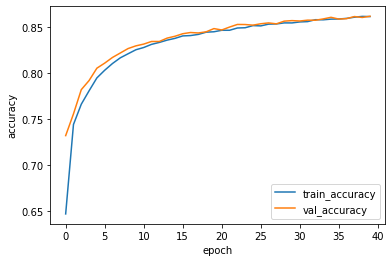

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [24]:
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
model.evaluate(x_val, y_val_encoded, verbose=0)

[0.39460089802742004, 0.8617500066757202]